In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root="data", download=True, transform=ToTensor())

In [3]:
# Viewing the shape of an image item and the label associated with it
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

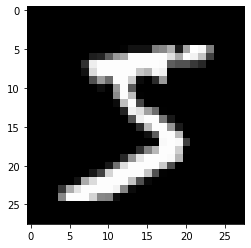

In [4]:
# Plotting an image item using pyplot
img, label = train_data[0]
plt.imshow(img.permute(1,2,0), cmap="gray")

In [5]:
# Splitting dataset in training and validation set
train_set, val_set = random_split(train_data, [50000, 10000])
len(train_set), len(val_set)

(50000, 10000)

In [6]:
# Define batch_size and create DataLoaders
# FAQs
## Why set shuffle=True? This is to ensure that in every pass of the load operation, the data
## shuffled and a random set of batch_size image items is selected to be loaded. (Sometimes, the
## dataset may have items in a certain pattern or order. Just to break that.)

batch_size = 100
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size, num_workers=4, pin_memory=True)

In [7]:
# Defining the Neural Network
# There are 2 mandatory methods that you need to implement:
## __init__ and forward

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions, triggers forward(self, xb)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions, triggers forward(self, xb)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    def get_default_device():
        """Pick GPU if available, else CPU"""
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
        
    def predict_image(self, img):
        device = ""
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        xb = to_device(img.unsqueeze(0), device)
        yb = self(xb) 
        _, preds  = torch.max(yb, dim=1)
        return preds[0].item()

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The next Section is dedicated to GPU specific code. To ensure that we are using a GPU, if available, for the computations.

In [9]:
# To check if GPU is available
torch.cuda.is_available()

False

In [10]:
# Helper function to ensure that our code uses GPU if available, else CPU.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
# Check what device was selected in the step above
device = get_default_device()
device

device(type='cpu')

In [12]:
# Function to move the data to the chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
# Create a DeviceDataLoader class to wrap our existing loaders, and move data to chosen device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
# Wrap our existing data loaders using DeviceDataLoader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

The following section is dedicated to training the model

In [15]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
# Instantiate the model class and load onto the selected device
model = MnistModel(784, hidden_size=32, out_size=10)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.306046485900879, 'val_acc': 0.1087999939918518}]

In [18]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2188, val_acc: 0.9371
Epoch [1], val_loss: 0.1892, val_acc: 0.9445
Epoch [2], val_loss: 0.1597, val_acc: 0.9541
Epoch [3], val_loss: 0.1559, val_acc: 0.9561
Epoch [4], val_loss: 0.1500, val_acc: 0.9574


In [19]:
history += fit(5, 0.2, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1333, val_acc: 0.9610
Epoch [1], val_loss: 0.1318, val_acc: 0.9619
Epoch [2], val_loss: 0.1327, val_acc: 0.9625
Epoch [3], val_loss: 0.1310, val_acc: 0.9620
Epoch [4], val_loss: 0.1325, val_acc: 0.9616


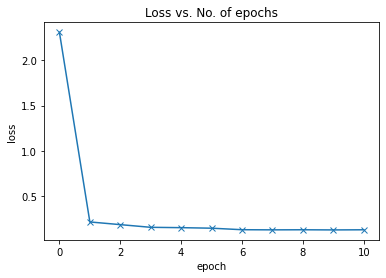

In [20]:
# Plot the loss
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x') # '-x' -> x the data points and draw a line through them
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

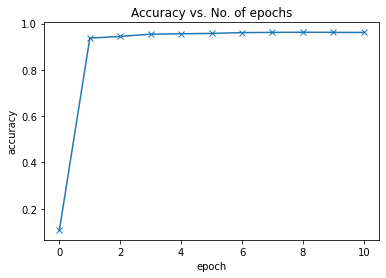

In [21]:
# Plot the accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

The following section contains function that will be called when we want to make a prediction.

In [22]:
def predict_image(model, img):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 5 , Predicted: 5


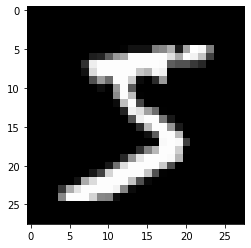

In [23]:
img, label = train_data[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', model.predict_image(img))

In [24]:
import pickle

# Save the model to a file using pickle
with open('digit-classification-nn.pkl', 'wb') as file:
    pickle.dump(model, file)

In [25]:
img, label = train_data[0]
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [26]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [27]:
import pickle

# Save to file in the current working directory
with open('digit-classification-nn.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open('digit-classification-nn.pkl', 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
img, label = train_data[2]
score = pickle_model.predict_image(img)
score, label

(4, 4)

3


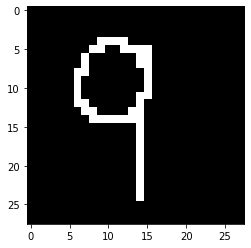

In [31]:
image = np.zeros((28, 28))

# Set the pixels to represent the digit 4
image = [
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ]
]
# image[5:23, 8:18] = 1.0  # Set a rectangular region to 1.0 (white) to form the digit 4
image_tensor = torch.tensor(image, dtype=torch.float32)
# tensor = torch.tensor(python_list, dtype=torch.float32)

prediction = model.predict_image(image_tensor)
print(prediction)
plt.imshow(image, cmap='gray')